<a href="https://colab.research.google.com/github/mollyapsel/RegionalLinguisticBias/blob/main/ling_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import Word2Vec
from gensim.models import FastText
import numpy as np
import os
import pandas as pd
import scipy.stats as stats

regions = {1: ['WA', 'OR', 'CA', 'AK', 'HI'], 2: ['AZ', 'NM', 'TX', 'NV', 'UT'], 3: ['MT', 'WY', 'CO', 'ID'], 4: ['ND', 'SD', 'NE', 'KS', 'OK', 'MO', 'IA'], 5: ['MN', 'WI', 'IL', 'MI', 'OH'], 6: ['MS', 'LA', 'AL', 'GA', 'FL', 'SC', 'KY', 'TN', 'AR', 'IN', 'WV'], 7: ['NY', 'NJ', 'PA'], 8: ['ME', 'NH', 'VT', 'MA', 'RI', 'CT'], 9:['VA','DC','MD','DE','NC']}


# Word2Vec & FastText tests

In [ ]:
  # make csv with region, effect size and p-values

  # make function to check whether all stimuli are valid
  # run all analyses both removing just invalid words and removing invalid words + equal number from counterpart set
  # Try:
  # Except KeyError:

IndentationError: expected an indented block after function definition on line 7 (<ipython-input-11-706af5b3b929>, line 9)

In [ ]:
def check_keys1(model, X, Y, A, B):
  X1 = X.copy()
  Y1 = Y.copy()
  A1 = A.copy()
  B1 = B.copy()

  for x in X:
    try:
      model.wv[x]
    except KeyError:
      # remove x from X and print x
      print(x)
      X1.remove(x)
  for y in Y:
    try:
      model.wv[y]
    except KeyError:
      # remove y from Y and print y
      print(y)
      Y1.remove(y)
  for a in A:
    try:
      model.wv[a]
    except KeyError:
      # remove a from A and print a
      print(a)
      A1.remove(a)
  for b in B:
    try:
      model.wv[b]
    except KeyError:
      # remove b from B and print b
      print(b)
      B1.remove(b)
  return X1, Y1, A1, B1

In [ ]:
def check_keys2(model, X, Y, A, B):
  x1, y1, a1, b1 = check_keys1(model, X, Y, A, B) # valid keys of each set
  if len(x1) > len(y1):
    diff = len(x1) - len(y1)
    # remove diff number of random items from x1
    for i in range(diff):
      pos = np.random.randint(0, len(x1))
      print("removed", x1[pos])
      x1.pop(pos)
  elif len(x1) < len(y1):
    diff = len(y1) - len(x1)
    # remove diff number of random items from y1
    for i in range(diff):
      pos = np.random.randint(0, len(y1))
      print("removed", y1[pos])
      y1.pop(pos)
  if len(a1) > len(b1):
    diff = len(a1) - len(b1)
    # remove diff number of random items from a1
    for i in range(diff):
      pos = np.random.randint(0, len(a1))
      print("removed", a1[pos])
      a1.pop(pos)
  elif len(a1) < len(b1):
    diff = len(b1) - len(a1)
    # remove diff number of random items from b1
    for i in range(diff):
      pos = np.random.randint(0, len(b1))
      print("removed", b1[pos])
      b1.pop(pos)
  return x1, y1, a1, b1


In [ ]:

def weat_es(model, X, Y, A, B):
  # calculate the WEAT effect size given a word2vec model, target sets X and Y, and attribute sets A and B
  s_x = []
  s_y = []
  for x in X:
      s = np.mean([model.wv.similarity(x,a) for a in A]) - np.mean([model.wv.similarity(x,b) for b in B])
      s_x.append(s)

  for y in Y:
      s = np.mean([model.wv.similarity(y,a) for a in A]) - np.mean([model.wv.similarity(y,b) for b in B])
      s_y.append(s)

  diff = np.mean(s_x) - np.mean(s_y)
  pooled_sd = np.std(s_x+s_y)
  return diff / pooled_sd


In [ ]:
# add in permutation test for 1000
from itertools import combinations
import random

def get_parts(X, Y):
  if len(X)!=len(Y):
    return "uneven target set lengths"

  all_combinations = [random.sample(X+Y, len(X)) for _ in range(1000)]

  equal_splits = []
  for combo in all_combinations:
      remaining = list(X+Y)
      for item in combo:
          remaining.remove(item)
      equal_splits.append((list(combo), remaining))
  return equal_splits

def p_test(X, Y, A, B, model, equal_splits):
  s_w = {}
  for i in X+Y:
    s_w[i] = np.mean([model.wv.similarity(i, a) for a in A]) - np.mean([model.wv.similarity(i, b) for b in B])

  obs = sum([s_w[x] for x in X]) - sum([s_w[y] for y in Y])

  stats = np.array([sum([s_w[x] for x in part[0]]) - sum([s_w[y] for y in part[1]]) for part in equal_splits])
  numerator = np.sum(stats > obs)
  #print("Numerator: ", numerator)
  denominator = len(stats)
  #print("Denominator: ", denominator)
  p =  numerator / denominator
  return p

In [ ]:
r1 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r1_ft.model')
r2 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r2_ft.model')
r3 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r3_ft.model')
r4 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r4_ft.model')
r5 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r5_ft.model')
r6 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r6_ft.model')
r7 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r7_ft.model')
r8 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r8_ft.model')
r9 = FastText.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/ft_regions/r9_ft.model')

In [ ]:
r1 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r1_word2vec.model')
r2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r2_word2vec.model')
r3 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r3_word2vec.model')
r4 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r4_word2vec.model')
r5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r5_word2vec.model')
r6 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r6_word2vec.model')
r7 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r7_word2vec.model')
r8 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r8_word2vec.model')
r9 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions/r9_word2vec.model')

KeyboardInterrupt: 

In [ ]:
# mincount = 2
r1_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r1_word2vec-mc2.model')
r2_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r2_word2vec-mc2.model')
r3_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r3_word2vec-mc2.model')
r4_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r4_word2vec-mc2.model')
r5_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r5_word2vec-mc2.model')
r6_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r6_word2vec-mc2.model')
r7_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r7_word2vec-mc2.model')
r8_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r8_word2vec-mc2.model')
r9_2 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc2/r9_word2vec-mc2.model')

In [ ]:
# mincount = 5
r1_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r1_word2vec-mc5.model')
r2_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r2_word2vec-mc5.model')
r3_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r3_word2vec-mc5.model')
r4_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r4_word2vec-mc5.model')
r5_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r5_word2vec-mc5.model')
r6_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r6_word2vec-mc5.model')
r7_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r7_word2vec-mc5.model')
r8_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r8_word2vec-mc5.model')
r9_5 = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_regions-mc5/r9_word2vec-mc5.model')

In [ ]:
weat1 = {"X": ['aster', 'clover', 'hyacinth', 'marigold', 'poppy', 'azalea', 'crocus', 'iris', 'orchid', 'rose', 'bluebell', 'daffodil', 'lilac', 'pansy', 'tulip', 'buttercup', 'daisy', 'lily', 'peony', 'violet', 'carnation', 'gladiola','magnolia', 'petunia', 'zinnia'], "Y": ['ant', 'caterpillar', 'flea', 'locust', 'spider', 'bedbug', 'centipede', 'fly', 'maggot', 'tarantula', 'bee', 'cockroach', 'gnat', 'mosquito', 'termite', 'beetle', 'cricket', 'hornet', 'moth', 'wasp', 'blackfly', 'dragonfly', 'horsefly', 'roach', 'weevil'], "A":['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation'], "B": ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison']}
weat2 = {"X": ['bagpipe', 'cello', 'guitar', 'lute', 'trombone', 'banjo', 'clarinet', 'harmonica', 'mandolin', 'trumpet', 'bassoon', 'drum', 'harp', 'oboe', 'tuba', 'bell', 'fiddle', 'harpsichord', 'piano', 'viola', 'bongo', 'flute', 'horn', 'saxophone', 'violin'], "Y": ['arrow', 'club', 'gun', 'missile', 'spear', 'axe', 'dagger', 'harpoon', 'pistol', 'sword', 'blade', 'dynamite', 'hatchet', 'rifle', 'tank', 'bomb', 'firearm', 'knife', 'shotgun', 'teargas', 'cannon', 'grenade', 'mace', 'slingshot', 'whip'], "A": ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation'], "B": ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison']}
weat3 = {"X": "Adam, Chip, Harry, Josh, Roger, Alan, Frank, Ian, Justin, Ryan, Andrew, Fred, Jack, Matthew, Stephen, Brad, Greg, Jed, Paul, Todd, Brandon, Hank, Jonathan, Peter, Wilbur, Amanda, Courtney, Heather, Melanie, Sara, Amber, Crystal, Katie, Meredith, Shannon, Betsy, Donna, Kristin, Nancy, Stephanie, Bobbie-Sue, Ellen, Lauren, Peggy, Sue-Ellen, Colleen, Emily, Megan, Rachel, Wendy".lower().split(", "), "Y": "Alonzo, Jamel, Lerone, Percell, Theo, Alphonse, Jerome, Leroy, Rasaan, Torrance, Darnell, Lamar, Lionel, Rashaun, Tyree, Deion, Lamont, Malik, Terrence, Tyrone, Everol, Lavon, Marcellus, Terryl, Wardell, Aiesha, Lashelle, Nichelle, Shereen, Temeka, Ebony, Latisha, Shaniqua, Tameisha, Teretha, Jasmine, Latonya, Shanise, Tanisha, Tia, Lakisha, Latoya, Sharise, Tashika, Yolanda, Lashandra, Malika, Shavonn, Tawanda, Yvette".lower().split(", "), "A": ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation'], "B": ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy','bomb', 'divorce', 'jail', 'poverty', 'ugly', 'cancer','evil', 'kill', 'rotten', 'vomit']}
weat4 = {"X": "Brad, Brendan, Geoffrey, Greg, Brett, Jay, Matthew, Neil, Todd, Allison, Anne, Carrie, Emily, Jill, Laurie, Kristen, Meredith, Sarah".lower().split(", "), "Y": "Darnell, Hakim, Jermaine, Kareem, Jamal, Leroy, Rasheed, Tremayne, Tyrone, Aisha, Ebony, Keisha, Kenya, Latonya, Lakisha, Latoya, Tamika, Tanisha".lower().split(", "), "A": ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation'], "B": ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy','bomb', 'divorce', 'jail', 'poverty', 'ugly', 'cancer','evil', 'kill', 'rotten', 'vomit']}
weat5 = {"X": "Brad, Brendan, Geoffrey, Greg, Brett, Jay, Matthew, Neil, Todd, Allison, Anne, Carrie, Emily, Jill, Laurie, Kristen, Meredith, Sarah".lower().split(", "), "Y": "Darnell, Hakim, Jermaine, Kareem, Jamal, Leroy, Rasheed, Tremayne, Tyrone, Aisha, Ebony, Keisha, Kenya, Latonya, Lakisha, Latoya, Tamika, Tanisha".lower().split(", "), "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'friend', 'laughter', 'happy'], "B":['agony', 'terrible', 'horrible', 'nasty', 'evil', 'war', 'awful', 'failure']}
weat6 = {"X":[w.lower() for w in ['John', 'Paul', 'Mike', 'Kevin', 'Steve', 'Greg', 'Jeff', 'Bill']], "Y":[w.lower() for w in ['Amy', 'Joan', 'Lisa', 'Sarah', 'Diana', 'Kate', 'Ann', 'Donna']],"A":['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career'], "B": ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']}
weat7 = {"X": ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition'], "Y": ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture'], "A": ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son'], "B": ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']}
weat8 = {"X": [w.lower() for w in ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']], "Y" :[w.lower() for w in ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']], "A": ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him'], "B": ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']}
weat9 = {"X":['sad', 'hopeless', 'gloomy', 'tearful', 'miserable', 'depressed'], "Y": ['sick', 'illness', 'influenza', 'disease', 'virus', 'cancer'], "A": ['impermanent', 'unstable', 'variable', 'fleeting', 'short', 'brief', 'occasional'], "B": ['stable', 'always', 'constant', 'persistent', 'chronic', 'prolonged', 'forever']}
weat10 = {"X": [w.lower() for w in ['Tiffany', 'Michelle', 'Cindy', 'Kristy', 'Brad', 'Eric', 'Joey', 'Billy']], "Y": [w.lower() for w in ['Ethel', 'Bernice', 'Gertrude', 'Agnes', 'Cecil', 'Wilbert', 'Mortimer', 'Edgar']], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'friend', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'war', 'awful', 'failure']}

In [ ]:
tests = [weat1, weat2, weat3, weat4, weat5, weat6, weat7, weat8, weat9, weat10]
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
def run_tests(tests, models):
  for test in tests:
    results = {"region": [1,2,3,4,5,6,7,8,9], "effect_size": [], "p_value": [], "x":[], "x_n": [], "y":[], "y_n": [],"a":[], "a_n": [],"b":[], "b_n": []}
    num = tests.index(test) + 1
    for model in models:
      x,y,a,b = check_keys2(model, test["X"], test["Y"], test["A"], test["B"])
      es = weat_es(model, x, y, a, b)
      parts = get_parts(x, y)
      p = p_test(x, y, a, b, model, parts)
      results["effect_size"].append(es)
      results["p_value"].append(p)
      results["x"].append(x)
      results["x_n"].append(len(x))
      results["y"].append(y)
      results["y_n"].append(len(y))
      results["a"].append(a)
      results["a_n"].append(len(a))
      results["b"].append(b)
      results["b_n"].append(len(b))
    pd.DataFrame(results).to_csv(f"/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_weat{num}.csv", index=False)
  return

In [ ]:
run_tests(tests, models)

blackfly
horsefly
removed pansy
removed daffodil
peony
gladiola
blackfly
horsefly
orchid
bluebell
daffodil
gladiola
zinnia
gnat
termite
blackfly
weevil
caress
removed locust
removed assault
bluebell
gladiola
zinnia
gnat
blackfly
horsefly
weevil
removed poppy
blackfly
removed clover
gladiola
blackfly
bluebell
blackfly
horsefly
removed zinnia
gladiola
blackfly
harpsichord
bongo
teargas
caress
removed blade
removed pollute
bongo
removed slingshot
bobbie-sue
sue-ellen
lerone
rasaan
everol
aiesha
lashelle
temeka
tameisha
teretha
shanise
tashika
lashandra
shavonn
tawanda
removed amanda
removed matthew
removed wendy
removed heather
removed wilbur
removed lauren
removed jack
removed chip
removed colleen
removed todd
removed sara
bobbie-sue
sue-ellen
lerone
percell
rasaan
everol
aiesha
lashelle
temeka
tameisha
teretha
sharise
tashika
lashandra
shavonn
tawanda
removed meredith
removed shannon
removed hank
removed todd
removed sara
removed roger
removed katie
removed josh
removed brad
removed har

## Newer tests

In [ ]:
#models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
def run_test(test, models):
  results = {"region": [1,2,3,4,5,6,7,8,9], "effect_size": [], "p_value": [], "x":[], "x_n": [], "y":[], "y_n": [],"a":[], "a_n": [],"b":[], "b_n": []}
  for model in models:
    x,y,a,b = check_keys2(model, test["X"], test["Y"], test["A"], test["B"])
    es = weat_es(model, x, y, a, b)
    parts = get_parts(x, y)
    p = p_test(x, y, a, b, model, parts)
    results["effect_size"].append(es)
    results["p_value"].append(p)
    results["x"].append(x)
    results["x_n"].append(len(x))
    results["y"].append(y)
    results["y_n"].append(len(y))
    results["a"].append(a)
    results["a_n"].append(len(a))
    results["b"].append(b)
    results["b_n"].append(len(b))
  return pd.DataFrame(results)

In [ ]:
# target images replaced with names from Caliskan et al. (2017)/ Nosek et al. (2002)
age = {"X": [w.lower() for w in ['Tiffany', 'Michelle', 'Cindy', 'Kristy', 'Brad', 'Eric', 'Joey', 'Billy']], "Y": [w.lower() for w in ['Ethel', 'Bernice', 'Gertrude', 'Agnes', 'Cecil', 'Wilbert', 'Mortimer', 'Edgar']], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
agedf = run_test(age, models)
agedf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_ageweat.csv", index=False)

wilbert
removed joey


In [ ]:
# target images replaced with names from Caliskan et al. (2017)/ Nosek et al. (2002)
age = {"X": [w.lower() for w in ['Tiffany', 'Michelle', 'Cindy', 'Kristy', 'Brad', 'Eric', 'Joey', 'Billy']], "Y": [w.lower() for w in ['Ethel', 'Bernice', 'Gertrude', 'Agnes', 'Cecil', 'Wilbert', 'Mortimer', 'Edgar']], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
agedf = run_test(age, models)
agedf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_agenameweat.csv", index=False)

In [ ]:
# target images replaced with words from Morehouse et al. (2023)
age_w = {"X": ['young', 'youth','youthful', 'child', 'children', 'youngster'], "Y": ['elder', 'elders', 'elderly', 'aged', 'grandmother', 'grandfather'], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
age_wdf = run_test(age_w, models)
age_wdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_agewordweat.csv", index=False)

In [ ]:
# target images replaced with words from Morehouse et al. (2023)
age_w = {"X": ['young', 'youth','youthful', 'child', 'children', 'youngster'], "Y": ['elder', 'elders', 'elderly', 'aged', 'grandmother', 'grandfather'], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
age_wdf = run_test(age_w, models)
age_wdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_agewordweat.csv", index=False)

In [ ]:

arab = {"X": [w.lower() for w in ["Ernesto", "Matthais", "Maarten", "Philippe", "Guillame", "Benoit", "Takuya", "Kazuki", "Chaiyo", "Marcelo"]], "Y": [w.lower() for w in ["Hakim", "Sharif", "Yousef", "Wahib", "Muhsin", "Salim", "Karim", "Habib", "Ashraf", "Akbar"]], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
arabdf = run_test(arab, models)
arabdf

In [ ]:
arabdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_arabweat.csv", index=False)

In [ ]:
arab = {"X": [w.lower() for w in ["Ernesto", "Matthais", "Maarten", "Philippe", "Guillame", "Benoit", "Takuya", "Kazuki", "Chaiyo", "Marcelo"]], "Y": [w.lower() for w in ["Hakim", "Sharif", "Yousef", "Wahib", "Muhsin", "Salim", "Karim", "Habib", "Ashraf", "Akbar"]], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
arabdf = run_test(arab, models)
arabdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_arabweat.csv", index=False)

In [ ]:
# target images replaced with names from Morehouse et al. (2023)
asian = {"X": ['smith', 'jones', 'adams', 'harris', 'miller', 'perry', 'johnson'], "Y": ['chang', 'hwang', 'wong', 'chen', 'nguyen', 'fujimoto', 'lee'], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
asiandf = run_test(asian, models)
asiandf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_asianattitudeweat.csv", index=False)

fujimoto
removed perry


In [ ]:
# target images replaced with names from Morehouse et al. (2023)
asian = {"X": ['smith', 'jones', 'adams', 'harris', 'miller', 'perry', 'johnson'], "Y": ['chang', 'hwang', 'wong', 'chen', 'nguyen', 'fujimoto', 'lee'], "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
asiandf = run_test(asian, models)
asiandf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_asianattitudeweat.csv", index=False)

In [ ]:
# uses name stimuli from Project Implicit rather than from Caliskan et al. (2017)
gendercareer = {"X":[w.lower() for w in ['Ben', 'Paul', 'Daniel', 'John', 'Jeffrey']], "Y":[w.lower() for w in ['Rebecca', 'Michelle', 'Emily', 'Julia', 'Anna']],"A":['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career'], "B": ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']}
gendercareerdf = run_test(gendercareer, models)
gendercareerdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_gendercareerweat.csv", index=False)

In [ ]:
# uses name stimuli from Project Implicit rather than from Caliskan et al. (2017)
gendercareer = {"X":[w.lower() for w in ['Ben', 'Paul', 'Daniel', 'John', 'Jeffrey']], "Y":[w.lower() for w in ['Rebecca', 'Michelle', 'Emily', 'Julia', 'Anna']],"A":['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career'], "B": ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']}
gendercareerdf = run_test(gendercareer, models)
gendercareerdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_gendercareerweat.csv", index=False)

In [ ]:
genderscience = {"X": [w.lower() for w in "Man, Son, Father, Boy, Uncle, Grandpa, Husband, Male".split(", ")], "Y": [w.lower() for w in "Mother, Wife, Aunt, Woman, Girl, Female, Grandma, Daughter".split(", ")], "A": [w.lower() for w in "Astronomy, Math, Chemistry, Physics, Biology, Geology, Engineering".split(", ")], "B": [w.lower() for w in "History, Arts, Humanities, English, Philosophy, Music, Literature".split(", ")]}
gendersciencedf = run_test(genderscience, models)
gendersciencedf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_genderscienceweat.csv", index=False)

In [ ]:
genderscience = {"X": [w.lower() for w in "Man, Son, Father, Boy, Uncle, Grandpa, Husband, Male".split(", ")], "Y": [w.lower() for w in "Mother, Wife, Aunt, Woman, Girl, Female, Grandma, Daughter".split(", ")], "A": [w.lower() for w in "Astronomy, Math, Chemistry, Physics, Biology, Geology, Engineering".split(", ")], "B": [w.lower() for w in "History, Arts, Humanities, English, Philosophy, Music, Literature".split(", ")]}
gendersciencedf = run_test(genderscience, models)
gendersciencedf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_genderscienceweat.csv", index=False)

In [ ]:
hispanic = {"X": [w.lower() for w in ['McDonald', 'OBrien', 'Kelly', 'Smith', 'Foster', 'Wallace', 'Andrews', 'Robertson']], "Y": [w.lower() for w in ['Torres', 'Vargas', 'Castillo', 'Ramos', 'Perez', 'Garcia', 'Rodriguez', 'Guerrero']], "A": [w.lower() for w in ['Celebrate', 'Fabulous', 'Lovely', 'Love', 'Delightful', 'Friend', 'Adore', 'Magnificent']], "B": [w.lower() for w in ['Rotten', 'Evil', 'Abuse', 'Humiliate', 'Nasty', 'Annoy', 'Dirty', 'Poison']]}
hispanicdf = run_test(hispanic, models)
hispanicdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_hispanicweat.csv", index=False)

In [ ]:
hispanic = {"X": [w.lower() for w in ['McDonald', 'OBrien', 'Kelly', 'Smith', 'Foster', 'Wallace', 'Andrews', 'Robertson']], "Y": [w.lower() for w in ['Torres', 'Vargas', 'Castillo', 'Ramos', 'Perez', 'Garcia', 'Rodriguez', 'Guerrero']], "A": [w.lower() for w in ['Celebrate', 'Fabulous', 'Lovely', 'Love', 'Delightful', 'Friend', 'Adore', 'Magnificent']], "B": [w.lower() for w in ['Rotten', 'Evil', 'Abuse', 'Humiliate', 'Nasty', 'Annoy', 'Dirty', 'Poison']]}
hispanicdf = run_test(hispanic, models)
hispanicdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_hispanicweat.csv", index=False)

In [ ]:
# target images replaced by words from Morehouse et al. (2023)
jewish = {"X": "church, minister, priest, gospels, christmas, christian, easter, sunday".split(", "), "Y": "synagogue, rabbi, torah, talmud, hanukkah, jewish, shabbat, sabbath".split(", "), "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
jewishdf = run_test(jewish, models)
jewishdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_jewishweat.csv", index=False)

In [ ]:
# target images replaced by words from Morehouse et al. (2023)
jewish = {"X": "church, minister, priest, gospels, christmas, christian, easter, sunday".split(", "), "Y": "synagogue, rabbi, torah, talmud, hanukkah, jewish, shabbat, sabbath".split(", "), "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
jewishdf = run_test(jewish, models)
jewishdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_jewishweat.csv", index=False)

In [ ]:
native = {"X": [w.lower() for w in ['Adams', 'Allen', 'Baker', 'Clark', 'Hall', 'Nelson', 'Scott', 'Wright', 'Anderson', 'Thompson', 'Campbell', 'Bennett', 'Mitchell']], "Y": [w.lower() for w in ['Awiakta', 'Wahchumwah', 'Chippewa', 'Suwake', 'Tsosie', 'Akiwenzie', 'Ojibway', 'Pewaush', 'Apache', 'Chosa', 'Kiatta', 'Homma', 'Pappan']], "A": [w.lower() for w in ['Alive', 'Current', 'Living', 'Present', 'Now', 'New', 'Modern', 'Contemporary']], "B": [w.lower() for w in ['Deceased', 'Vanished', 'Dead', 'Extinct', 'Ancient', 'Historic', 'Past', 'Old']]}
native_df = run_test(native, models)
native_df.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_nativeamericanweat.csv", index=False)

awiakta
wahchumwah
suwake
akiwenzie
pewaush
chosa
kiatta
homma
pappan
removed campbell
removed wright
removed allen
removed baker
removed mitchell
removed thompson
removed hall
removed bennett
removed scott
awiakta
wahchumwah
suwake
akiwenzie
ojibway
pewaush
chosa
kiatta
homma
pappan
removed nelson
removed bennett
removed wright
removed hall
removed anderson
removed baker
removed adams
removed thompson
removed clark
removed campbell
awiakta
wahchumwah
suwake
tsosie
akiwenzie
ojibway
pewaush
chosa
kiatta
homma
pappan
removed mitchell
removed thompson
removed adams
removed nelson
removed hall
removed anderson
removed bennett
removed campbell
removed scott
removed allen
removed baker
awiakta
wahchumwah
suwake
akiwenzie
pewaush
chosa
kiatta
homma
pappan
removed allen
removed clark
removed bennett
removed scott
removed baker
removed anderson
removed nelson
removed campbell
removed mitchell
awiakta
wahchumwah
suwake
tsosie
akiwenzie
pewaush
chosa
kiatta
homma
removed bennett
removed anderson

In [ ]:
native = {"X": [w.lower() for w in ['Adams', 'Allen', 'Baker', 'Clark', 'Hall', 'Nelson', 'Scott', 'Wright', 'Anderson', 'Thompson', 'Campbell', 'Bennett', 'Mitchell']], "Y": [w.lower() for w in ['Awiakta', 'Wahchumwah', 'Chippewa', 'Suwake', 'Tsosie', 'Akiwenzie', 'Ojibway', 'Pewaush', 'Apache', 'Chosa', 'Kiatta', 'Homma', 'Pappan']], "A": [w.lower() for w in ['Alive', 'Current', 'Living', 'Present', 'Now', 'New', 'Modern', 'Contemporary']], "B": [w.lower() for w in ['Deceased', 'Vanished', 'Dead', 'Extinct', 'Ancient', 'Historic', 'Past', 'Old']]}
native_df = run_test(native, models)
native_df.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_nativeamericanweat.csv", index=False)

In [ ]:
# target images replaced with names from Caliskan et al. (2017)/ Greenwald et al. (1998)
race_n = {"X": "Adam, Chip, Harry, Josh, Roger, Alan, Frank, Ian, Justin, Ryan, Andrew, Fred, Jack, Matthew, Stephen, Brad, Greg, Jed, Paul, Todd, Brandon, Hank, Jonathan, Peter, Wilbur, Amanda, Courtney, Heather, Melanie, Sara, Amber, Crystal, Katie, Meredith, Shannon, Betsy, Donna, Kristin, Nancy, Stephanie, BobbieSue, Ellen, Lauren, Peggy, SueEllen, Colleen, Emily, Megan, Rachel, Wendy".lower().split(", "), "Y": "Alonzo, Jamel, Lerone, Percell, Theo, Alphonse, Jerome, Leroy, Rasaan, Torrance, Darnell, Lamar, Lionel, Rashaun, Tyree, Deion, Lamont, Malik, Terrence, Tyrone, Everol, Lavon, Marcellus, Terryl, Wardell, Aiesha, Lashelle, Nichelle, Shereen, Temeka, Ebony, Latisha, Shaniqua, Tameisha, Teretha, Jasmine, Latonya, Shanise, Tanisha, Tia, Lakisha, Latoya, Sharise, Tashika, Yolanda, Lashandra, Malika, Shavonn, Tawanda, Yvette".lower().split(", "), "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
race_ndf = run_test(race_n, models)
race_ndf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_racenameweat.csv", index=False)

bobbiesue
sueellen
lerone
rasaan
everol
aiesha
lashelle
temeka
tameisha
teretha
shanise
tashika
lashandra
shavonn
tawanda
removed wilbur
removed colleen
removed stephanie
removed peggy
removed emily
removed kristin
removed heather
removed roger
removed donna
removed lauren
removed shannon
bobbiesue
sueellen
lerone
percell
rasaan
everol
aiesha
lashelle
temeka
tameisha
teretha
sharise
tashika
lashandra
shavonn
tawanda
removed heather
removed wendy
removed todd
removed megan
removed greg
removed peggy
removed kristin
removed betsy
removed stephen
removed lauren
removed roger
removed jonathan
bobbiesue
sueellen
lerone
percell
alphonse
rasaan
rashaun
everol
lavon
terryl
aiesha
nichelle
shereen
temeka
shaniqua
tameisha
teretha
latonya
shanise
lakisha
sharise
tashika
lashandra
shavonn
tawanda
removed emily
removed josh
removed jonathan
removed crystal
removed megan
removed brad
removed adam
removed colleen
removed rachel
removed amanda
removed lauren
removed wendy
removed brandon
removed jed


In [ ]:
# target images replaced with names from Caliskan et al. (2017)/ Greenwald et al. (1998)
race_n = {"X": "Adam, Chip, Harry, Josh, Roger, Alan, Frank, Ian, Justin, Ryan, Andrew, Fred, Jack, Matthew, Stephen, Brad, Greg, Jed, Paul, Todd, Brandon, Hank, Jonathan, Peter, Wilbur, Amanda, Courtney, Heather, Melanie, Sara, Amber, Crystal, Katie, Meredith, Shannon, Betsy, Donna, Kristin, Nancy, Stephanie, BobbieSue, Ellen, Lauren, Peggy, SueEllen, Colleen, Emily, Megan, Rachel, Wendy".lower().split(", "), "Y": "Alonzo, Jamel, Lerone, Percell, Theo, Alphonse, Jerome, Leroy, Rasaan, Torrance, Darnell, Lamar, Lionel, Rashaun, Tyree, Deion, Lamont, Malik, Terrence, Tyrone, Everol, Lavon, Marcellus, Terryl, Wardell, Aiesha, Lashelle, Nichelle, Shereen, Temeka, Ebony, Latisha, Shaniqua, Tameisha, Teretha, Jasmine, Latonya, Shanise, Tanisha, Tia, Lakisha, Latoya, Sharise, Tashika, Yolanda, Lashandra, Malika, Shavonn, Tawanda, Yvette".lower().split(", "), "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
race_ndf = run_test(race_n, models)
race_ndf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_racenameweat.csv", index=False)

In [ ]:
# target images replaced with words from Morehouse et al. (2023)
race_w = {"X": "whites, european, europeans, american, british, english".split(", "), "Y": "blacks, african, africans, negro, negroes, afro".split(", "), "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
race_wdf = run_test(race_w, models)
race_wdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_racewordweat.csv", index=False)

In [ ]:
# target images replaced with words from Morehouse et al. (2023)
race_w = {"X": "whites, european, europeans, american, british, english".split(", "), "Y": "blacks, african, africans, negro, negroes, afro".split(", "), "A": ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
race_wdf = run_test(race_w, models)
race_wdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_racewordweat.csv", index=False)

In [ ]:
# target words from Morehouse et al. (2023)
sexuality = {"X": "hetero, heterosexuals, heterosexual, het, heterosexuality, heteronormative".split(", "), "Y": "gay, lesbian, homosexual, homosexuals, queer, gays".split(", "), "A": ['beautiful', 'superb', 'joyful', 'wonderful', 'pleasure', 'glorious', 'lovely', 'marvelous'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'humiliate', 'tragic', 'awful', 'painful']}
sexualitydf = run_test(sexuality, models)
sexualitydf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_sexualityweat.csv", index=False)

hetero
heterosexuality
heteronormative
removed lesbian
removed gay
removed queer
hetero
heterosexuality
removed lesbian
removed gay


In [ ]:
# target words from Morehouse et al. (2023)
sexuality = {"X": "hetero, heterosexuals, heterosexual, het, heterosexuality, heteronormative".split(", "), "Y": "gay, lesbian, homosexual, homosexuals, queer, gays".split(", "), "A": ['beautiful', 'superb', 'joyful', 'wonderful', 'pleasure', 'glorious', 'lovely', 'marvelous'], "B": ['agony', 'terrible', 'horrible', 'nasty', 'humiliate', 'tragic', 'awful', 'painful']}
sexualitydf = run_test(sexuality, models)
sexualitydf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_sexualityweat.csv", index=False)

In [ ]:
transgender = {"X": ["cis", "cisgender", "cismen", "ciswomen"], "Y": ["trans", "transgender", "transmen", "transwomen"], "A": ["nice","pleasure","laughter", "glorious"], "B": ["nasty", "agony", "hurt", "rotten"]}
transgenderdf = run_test(transgender, models)
transgenderdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_transgenderweat.csv", index=False)

cismen
ciswomen
removed transwomen
removed transgender
cismen
ciswomen
removed transmen
removed trans
cismen
ciswomen
transmen
transwomen
cismen
ciswomen
transmen
transwomen
cismen
ciswomen
transmen
transwomen
cismen
ciswomen
transmen
removed transgender
ciswomen
removed transwomen
cismen
ciswomen
transmen
transwomen
cismen
removed transmen


In [ ]:
transgender = {"X": ["cis", "cisgender", "cismen", "ciswomen"], "Y": ["trans", "transgender", "transmen", "transwomen"], "A": ["nice","pleasure","laughter", "glorious"], "B": ["nasty", "agony", "hurt", "rotten"]}
transgenderdf = run_test(transgender, models)
transgenderdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_transgenderweat.csv", index=False)

In [ ]:
# target images replaced by words from Morehouse et al. (2023)
weight = {'X': 'thin, skinny, scrawny, thinness, slender, slim'.split(', '), 'Y': 'fat, overweight, obese, obesity, fatness, heavyset'.split(', '), 'A': ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], 'B': ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
weightdf = run_test(weight, models)
weightdf.to_csv("/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_weightweat.csv", index=False)

fatness
removed slender


In [ ]:
# target images replaced by words from Morehouse et al. (2023)
weight = {'X': 'thin, skinny, scrawny, thinness, slender, slim'.split(', '), 'Y': 'fat, overweight, obese, obesity, fatness, heavyset'.split(', '), 'A': ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'glorious', 'laughter', 'happy'], 'B': ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'hurt', 'awful', 'failure']}
weightdf = run_test(weight, models)
weightdf.to_csv("/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_weightweat.csv", index=False)

# word2vec-fastText correlations

In [ ]:
w2v_path = "/content/drive/MyDrive/Michelle Molly/w2v_region_weats/w2v_region_"
ft_path = "/content/drive/MyDrive/Michelle Molly/ft_region_weats/ft_region_"

topics = ["agename", "ageword", "arab", "asianattitude", "gendercareer", "genderscience", "hispanic", "jewish", "nativeamerican", "racename", "raceword", "sexuality", "transgender", "weight"]
for t in topics:
  w2v = pd.read_csv(w2v_path + t + "weat.csv")
  ft = pd.read_csv(ft_path + t + "weat.csv")
  col1 = w2v['effect_size'].to_numpy()
  col2 = ft['effect_size'].to_numpy()
  print(t)
  print(stats.pearsonr(col1, col2))

agename
PearsonRResult(statistic=0.5459403527023976, pvalue=0.12836400269505183)
ageword
PearsonRResult(statistic=0.8351438828426911, pvalue=0.005077675263387143)
arab
PearsonRResult(statistic=0.24900444712825925, pvalue=0.5182166243760933)
asianattitude
PearsonRResult(statistic=0.7190340379637873, pvalue=0.029029246649233707)
gendercareer
PearsonRResult(statistic=0.7783870151944062, pvalue=0.013478635203460935)
genderscience
PearsonRResult(statistic=0.12806346774631308, pvalue=0.7426505175951109)
hispanic
PearsonRResult(statistic=0.5099437258266846, pvalue=0.1607661146887418)
jewish
PearsonRResult(statistic=0.7882700036060158, pvalue=0.011609729997728083)
nativeamerican
PearsonRResult(statistic=0.12653871058529292, pvalue=0.745632406651389)
racename
PearsonRResult(statistic=0.6130614598488309, pvalue=0.07916926830268466)
raceword
PearsonRResult(statistic=0.8081120064772508, pvalue=0.008399951506616606)
sexuality
PearsonRResult(statistic=-0.5075244368273784, pvalue=0.1630971090807718)


# Plots

In [ ]:
corrs = {'Sexuality': 0.21, 'Race': 0.24, 'Native American': 0.47, 'Weight': -0.27, 'Jewish': 0.32, 'Asian': 0.36, 'Arab': 0, 'Age': 0.61, 'Gender': -0.15, 'Transgender': 0.19}

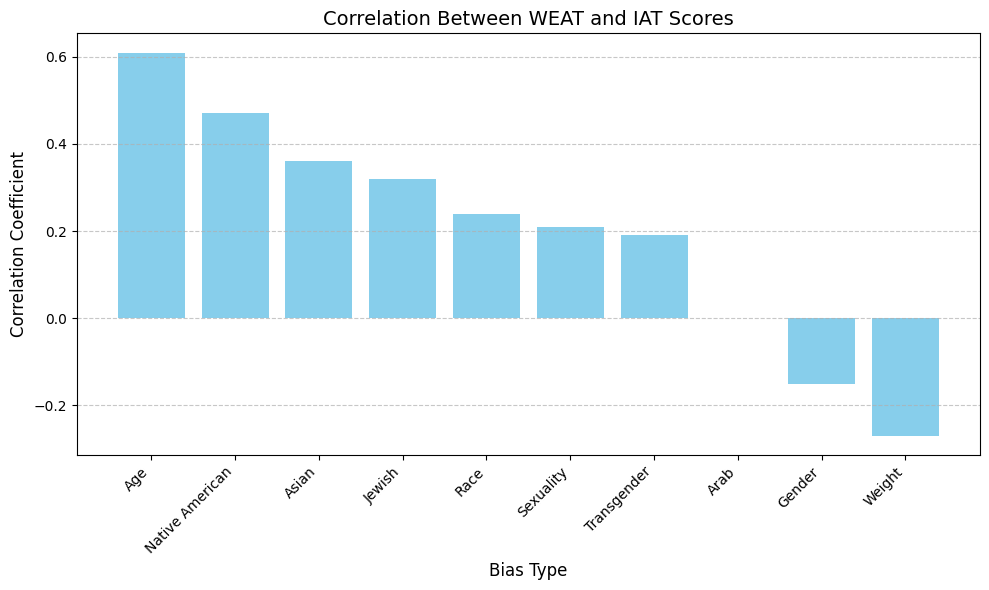

In [ ]:
# prompt: create a pretty plot that compares the values (correlation coefficients) associated with each key in corrs, sorted from highest to lowest

import matplotlib.pyplot as plt

corrs = {'Sexuality': 0.21, 'Race': 0.24, 'Native American': 0.47, 'Weight': -0.27, 'Jewish': 0.32, 'Asian': 0.36, 'Arab': 0, 'Age': 0.61, 'Gender': -0.15, 'Transgender': 0.19}

# Sort the correlations from highest to lowest
sorted_corrs = dict(sorted(corrs.items(), key=lambda item: item[1], reverse=True))

# Extract keys and values for plotting
keys = list(sorted_corrs.keys())
values = list(sorted_corrs.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel("Bias Type", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.title("Correlation Between WEAT and IAT Scores", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# WEAT 1: flowers vs. insects

In [ ]:
# targets: flowers and insects
X = ['aster', 'clover', 'hyacinth', 'marigold', 'poppy', 'azalea', 'crocus', 'iris', 'orchid', 'rose', 'bluebell', 'daffodil', 'lilac', 'pansy', 'tulip', 'buttercup', 'daisy', 'lily', 'peony', 'violet', 'carnation', 'gladiola','magnolia', 'petunia', 'zinnia']
Y = ['ant', 'caterpillar', 'flea', 'locust', 'spider', 'bedbug', 'centipede', 'fly', 'maggot', 'tarantula', 'bee', 'cockroach', 'gnat', 'mosquito', 'termite', 'beetle', 'cricket', 'hornet', 'moth', 'wasp', 'blackfly', 'dragonfly', 'horsefly', 'roach', 'weevil']
# attributes: pleasant and unpleasant
A = ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation']
B = ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison']

In [ ]:
len(X)

25

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

flowers_insects = pd.DataFrame(results)

crocus
daffodil
pansy
buttercup
peony
gladiola
petunia
zinnia
maggot
gnat
termite
blackfly
horsefly
weevil
caress
removed spider
removed cricket
removed crash
aster
hyacinth
marigold
azalea
crocus
bluebell
daffodil
lilac
pansy
buttercup
peony
carnation
gladiola
petunia
zinnia
bedbug
centipede
maggot
tarantula
cockroach
gnat
termite
blackfly
dragonfly
horsefly
weevil
caress
filth
removed locust
removed mosquito
removed hornet
removed roach
aster
clover
hyacinth
marigold
poppy
azalea
crocus
orchid
bluebell
daffodil
lilac
pansy
tulip
buttercup
daisy
peony
violet
carnation
gladiola
magnolia
petunia
zinnia
ant
caterpillar
flea
locust
bedbug
centipede
maggot
tarantula
cockroach
gnat
termite
hornet
moth
wasp
blackfly
dragonfly
horsefly
roach
weevil
caress
filth
stink
pollute
rotten
vomit
agony
removed cricket
removed mosquito
removed beetle
removed gift
removed freedom
removed laughter
removed honor
removed honest
aster
hyacinth
marigold
azalea
crocus
orchid
bluebell
daffodil
lilac
pansy
butt

In [ ]:
flowers_insects

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.318164,0.000,17,17,24,24
1,r2,1.114096,0.008,10,10,24,24
2,r3,0.618807,0.237,3,3,19,19
3,r4,0.937639,0.034,9,9,21,21
4,r5,1.238754,0.001,11,11,24,24
5,r6,1.380541,0.000,11,11,24,24
6,r7,1.472167,0.000,17,17,25,25
7,r8,1.599742,0.000,8,8,24,24
8,r9,1.418476,0.000,12,12,24,24


In [ ]:
# MC2
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

flowers_insects2 = pd.DataFrame(results)

blackfly
horsefly
removed buttercup
removed iris
peony
gladiola
blackfly
horsefly
orchid
bluebell
daffodil
gladiola
zinnia
gnat
termite
blackfly
weevil
caress
removed locust
removed hatred
bluebell
gladiola
zinnia
gnat
blackfly
horsefly
weevil
removed lilac
blackfly
removed gladiola
gladiola
blackfly
bluebell
blackfly
horsefly
removed zinnia
gladiola
blackfly


In [ ]:
flowers_insects2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.411905,0.000,23,23,25,25
1,r2,1.239394,0.000,23,23,25,25
2,r3,0.690521,0.017,20,20,24,24
3,r4,1.017719,0.000,21,21,25,25
4,r5,1.318704,0.000,24,24,25,25
5,r6,1.303350,0.000,24,24,25,25
6,r7,1.471418,0.000,25,25,25,25
7,r8,1.309541,0.000,23,23,25,25
8,r9,1.345453,0.000,24,24,25,25


In [ ]:
# MC5
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

flowers_insects5 = pd.DataFrame(results)

gladiola
blackfly
horsefly
removed petunia
crocus
peony
gladiola
zinnia
maggot
blackfly
horsefly
removed cricket
aster
azalea
crocus
orchid
bluebell
daffodil
pansy
peony
gladiola
petunia
zinnia
centipede
maggot
gnat
termite
blackfly
dragonfly
horsefly
weevil
caress
removed flea
removed beetle
removed bee
removed divorce
crocus
bluebell
pansy
peony
carnation
gladiola
petunia
zinnia
centipede
tarantula
gnat
blackfly
horsefly
weevil
caress
removed locust
removed wasp
removed kill
blackfly
removed lilac
bluebell
gladiola
blackfly
removed weevil
gladiola
blackfly
bluebell
gladiola
petunia
blackfly
horsefly
weevil
gladiola
blackfly
horsefly
removed rose


In [ ]:
flowers_insects5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.432857,0.000,23,23,25,25
1,r2,1.461212,0.000,21,21,25,25
2,r3,0.739048,0.033,14,14,24,24
3,r4,0.995220,0.000,17,17,24,24
4,r5,1.328339,0.000,24,24,25,25
5,r6,1.216575,0.000,23,23,25,25
6,r7,1.467498,0.000,24,24,25,25
7,r8,1.332535,0.000,22,22,25,25
8,r9,1.282955,0.000,23,23,25,25


Comments: about 1/3 of the flower/insect stimuli get lost for some regions when we increase min. count from 2 to 5

# WEAT 2: instruments vs. weapons

In [ ]:
# targets: instruments and weapons
X = ['bagpipe', 'cello', 'guitar', 'lute', 'trombone', 'banjo', 'clarinet', 'harmonica', 'mandolin', 'trumpet', 'bassoon', 'drum', 'harp', 'oboe', 'tuba', 'bell', 'fiddle', 'harpsichord', 'piano', 'viola', 'bongo', 'flute', 'horn', 'saxophone', 'violin']
Y = ['arrow', 'club', 'gun', 'missile', 'spear', 'axe', 'dagger', 'harpoon', 'pistol', 'sword', 'blade', 'dynamite', 'hatchet', 'rifle', 'tank', 'bomb', 'firearm', 'knife', 'shotgun', 'teargas', 'cannon', 'grenade', 'mace', 'slingshot', 'whip']
# attributes: pleasant and unpleasant
A = ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation']
B = ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison']

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

instruments_weapons = pd.DataFrame(results)

bagpipe
lute
bassoon
oboe
harpsichord
bongo
harpoon
caress
removed shotgun
removed gun
removed dagger
removed mace
removed missile
removed tragedy
bagpipe
lute
trombone
clarinet
mandolin
bassoon
oboe
harpsichord
bongo
harpoon
teargas
slingshot
caress
filth
removed tank
removed blade
removed club
removed spear
removed missile
removed axe
bagpipe
cello
lute
trombone
banjo
clarinet
harmonica
mandolin
trumpet
bassoon
harp
oboe
tuba
fiddle
harpsichord
viola
bongo
flute
saxophone
axe
dagger
harpoon
dynamite
hatchet
teargas
grenade
mace
slingshot
caress
filth
stink
pollute
rotten
vomit
agony
removed pistol
removed tank
removed spear
removed gun
removed whip
removed arrow
removed firearm
removed club
removed cannon
removed knife
removed lucky
removed laughter
removed love
removed rainbow
removed loyal
bagpipe
cello
lute
trombone
banjo
clarinet
harmonica
mandolin
bassoon
oboe
tuba
harpsichord
viola
bongo
saxophone
spear
dagger
harpoon
hatchet
teargas
mace
slingshot
caress
filth
stink
pollute
vo

In [ ]:
instruments_weapons

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.626899,0.0,19,19,24,24
1,r2,1.648298,0.0,16,16,24,24
2,r3,1.704398,0.0,6,6,19,19
3,r4,1.346928,0.0,10,10,21,21
4,r5,1.573523,0.0,17,17,24,24
5,r6,1.655716,0.0,19,19,24,24
6,r7,1.666360,0.0,22,22,25,25
7,r8,1.419975,0.0,14,14,24,24
8,r9,1.540338,0.0,20,20,24,24


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

instruments_weapons2 = pd.DataFrame(results)

harpsichord
bongo
teargas
caress
removed dynamite
removed assault
bongo
removed pistol


In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

instruments_weapons5 = pd.DataFrame(results)

lute
harpsichord
bongo
teargas
slingshot
caress
removed firearm
removed abuse
bagpipe
harpsichord
bongo
harpoon
caress
removed spear
removed shotgun
removed tragedy
bassoon
removed club


In [ ]:
instruments_weapons2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.621213,0.0,25,25,25,25
1,r2,1.470500,0.0,25,25,25,25
2,r3,1.498742,0.0,23,23,24,24
3,r4,1.651241,0.0,24,24,25,25
4,r5,1.565243,0.0,25,25,25,25
5,r6,1.703588,0.0,25,25,25,25
6,r7,1.685859,0.0,25,25,25,25
7,r8,1.373564,0.0,25,25,25,25
8,r9,1.590239,0.0,25,25,25,25


In [ ]:
instruments_weapons5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.640413,0.0,25,25,25,25
1,r2,1.470472,0.0,25,25,25,25
2,r3,1.458192,0.0,22,22,24,24
3,r4,1.637631,0.0,22,22,24,24
4,r5,1.621669,0.0,25,25,25,25
5,r6,1.729116,0.0,25,25,25,25
6,r7,1.713987,0.0,25,25,25,25
7,r8,1.501181,0.0,24,24,25,25
8,r9,1.533198,0.0,25,25,25,25


# WEAT 3: race A

In [ ]:
# targets: European American and African American names
X ="Adam, Chip, Harry, Josh, Roger, Alan, Frank, Ian, Justin, Ryan, Andrew, Fred, Jack, Matthew, Stephen, Brad, Greg, Jed, Paul, Todd, Brandon, Hank, Jonathan, Peter, Wilbur, Amanda, Courtney, Heather, Melanie, Sara, Amber, Crystal, Katie, Meredith, Shannon, Betsy, Donna, Kristin, Nancy, Stephanie, Bobbie-Sue, Ellen, Lauren, Peggy, Sue-Ellen, Colleen, Emily, Megan, Rachel, Wendy".lower().split(", ")
Y ="Alonzo, Jamel, Lerone, Percell, Theo, Alphonse, Jerome, Leroy, Rasaan, Torrance, Darnell, Lamar, Lionel, Rashaun, Tyree, Deion, Lamont, Malik, Terrence, Tyrone, Everol, Lavon, Marcellus, Terryl, Wardell, Aiesha, Lashelle, Nichelle, Shereen, Temeka, Ebony, Latisha, Shaniqua, Tameisha, Teretha, Jasmine, Latonya, Shanise, Tanisha, Tia, Lakisha, Latoya, Sharise, Tashika, Yolanda, Lashandra, Malika, Shavonn, Tawanda, Yvette".lower().split(", ")
# attributes: pleasant and unpleasant
A = ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation']
B = ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy','bomb', 'divorce', 'jail', 'poverty', 'ugly', 'cancer','evil', 'kill', 'rotten', 'vomit']

In [ ]:
print(len(X), len(Y))
print(len(A), len(B))

50 50
25 25


In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

race1 = pd.DataFrame(results)

bobbie-sue
sue-ellen
jamel
lerone
percell
alphonse
rasaan
rashaun
everol
terryl
aiesha
lashelle
nichelle
shereen
temeka
latisha
shaniqua
tameisha
teretha
latonya
shanise
tanisha
lakisha
sharise
tashika
lashandra
malika
shavonn
tawanda
caress
removed megan
removed ian
removed peter
removed stephen
removed amanda
removed roger
removed lauren
removed todd
removed harry
removed colleen
removed hank
removed matthew
removed betsy
removed sara
removed justin
removed wendy
removed melanie
removed josh
removed kristin
removed wilbur
removed emily
removed fred
removed adam
removed katie
removed chip
removed stink
bobbie-sue
sue-ellen
jamel
lerone
percell
alphonse
rasaan
torrance
rashaun
everol
terryl
wardell
aiesha
lashelle
nichelle
shereen
temeka
latisha
shaniqua
tameisha
teretha
latonya
shanise
tanisha
lakisha
sharise
tashika
lashandra
malika
shavonn
tawanda
caress
filth
removed todd
removed melanie
removed wilbur
removed brad
removed fred
removed ian
removed heather
removed wendy
removed paul

In [ ]:
race1

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.708899,0.005,23,23,24,24
1,r2,0.503394,0.048,21,21,24,24
2,r3,0.675066,0.213,4,4,20,20
3,r4,0.978448,0.011,12,12,21,21
4,r5,1.031811,0.000,21,21,24,24
5,r6,0.730505,0.009,22,22,24,24
6,r7,0.507634,0.043,25,25,25,25
7,r8,0.872180,0.007,13,13,24,24
8,r9,0.792965,0.001,22,22,24,24


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

race2 = pd.DataFrame(results)

bobbie-sue
sue-ellen
lerone
rasaan
everol
aiesha
lashelle
temeka
tameisha
teretha
shanise
tashika
lashandra
shavonn
tawanda
removed frank
removed jonathan
removed emily
removed andrew
removed jack
removed chip
removed stephanie
removed adam
removed greg
removed hank
removed roger
bobbie-sue
sue-ellen
lerone
percell
rasaan
everol
aiesha
lashelle
temeka
tameisha
teretha
sharise
tashika
lashandra
shavonn
tawanda
removed wilbur
removed peter
removed colleen
removed betsy
removed peggy
removed harry
removed sara
removed roger
removed amanda
removed greg
removed paul
removed donna
bobbie-sue
sue-ellen
lerone
percell
alphonse
rasaan
rashaun
everol
lavon
terryl
aiesha
nichelle
shereen
temeka
shaniqua
tameisha
teretha
latonya
shanise
lakisha
sharise
tashika
lashandra
shavonn
tawanda
caress
removed sara
removed katie
removed amanda
removed chip
removed stephanie
removed justin
removed adam
removed alan
removed jed
removed nancy
removed wilbur
removed ryan
removed fred
removed matthew
removed mer

In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

race5 = pd.DataFrame(results)

bobbie-sue
sue-ellen
lerone
rasaan
everol
aiesha
lashelle
temeka
tameisha
teretha
shanise
sharise
tashika
lashandra
shavonn
tawanda
removed crystal
removed jonathan
removed megan
removed nancy
removed lauren
removed amanda
removed courtney
removed ian
removed ellen
removed ryan
removed chip
removed stephanie
bobbie-sue
sue-ellen
lerone
percell
rasaan
rashaun
everol
terryl
wardell
aiesha
lashelle
shereen
temeka
shaniqua
tameisha
teretha
shanise
lakisha
sharise
tashika
lashandra
shavonn
tawanda
removed kristin
removed fred
removed rachel
removed frank
removed melanie
removed brandon
removed sara
removed donna
removed adam
removed todd
removed greg
removed stephen
removed wendy
removed matthew
removed chip
removed stephanie
removed ryan
removed jack
removed megan
bobbie-sue
sue-ellen
lerone
percell
alphonse
rasaan
rashaun
everol
lavon
terryl
wardell
aiesha
nichelle
shereen
temeka
shaniqua
tameisha
teretha
latonya
shanise
tanisha
lakisha
sharise
tashika
lashandra
malika
shavonn
tawanda
car

In [ ]:
race2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.523143,0.011,37,37,25,25
1,r2,0.536853,0.011,36,36,25,25
2,r3,1.067083,0.000,27,27,24,24
3,r4,0.858148,0.000,33,33,25,25
4,r5,0.770974,0.001,37,37,25,25
5,r6,0.755745,0.000,40,40,25,25
6,r7,0.471856,0.018,40,40,25,25
7,r8,0.706466,0.004,35,35,25,25
8,r9,0.862153,0.000,39,39,25,25


In [ ]:
race5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.596186,0.003,36,36,25,25
1,r2,0.478695,0.041,29,29,25,25
2,r3,0.680558,0.017,24,24,24,24
3,r4,0.842377,0.000,29,29,24,24
4,r5,0.823416,0.000,34,34,25,25
5,r6,0.553966,0.008,36,36,25,25
6,r7,0.319309,0.092,37,37,25,25
7,r8,0.555195,0.013,28,28,25,25
8,r9,0.784899,0.000,36,36,25,25


Comments: r3 is originally insignificant and not a relatively high effect size, but this changes when MC lowered to 2. All effects are significant when MC=2, but r7 becomes insignificant when MC=5. In either case, it is clear the data sparsity issues improve drastically.

# WEAT 4: race B

In [ ]:
# targets: European American and African American names
X = "Brad, Brendan, Geoffrey, Greg, Brett, Jay, Matthew, Neil, Todd, Allison, Anne, Carrie, Emily, Jill, Laurie, Kristen, Meredith, Sarah".lower().split(", ")
Y = "Darnell, Hakim, Jermaine, Kareem, Jamal, Leroy, Rasheed, Tremayne, Tyrone, Aisha, Ebony, Keisha, Kenya, Latonya, Lakisha, Latoya, Tamika, Tanisha".lower().split(", ")
# attributes: pleasant and unpleasant
A = ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation']
B = ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy','bomb', 'divorce', 'jail', 'poverty', 'ugly', 'cancer','evil', 'kill', 'rotten', 'vomit']

In [ ]:
print(len(X), len(Y))
print(len(A), len(B))

18 18
25 25


In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

raceb = pd.DataFrame(results)

tremayne
latonya
lakisha
tanisha
caress
removed sarah
removed geoffrey
removed anne
removed meredith
removed vomit
hakim
rasheed
tremayne
aisha
latonya
lakisha
tamika
tanisha
caress
filth
removed brendan
removed kristen
removed sarah
removed brad
removed todd
removed neil
removed jill
removed geoffrey
geoffrey
darnell
hakim
jermaine
rasheed
tremayne
tyrone
aisha
ebony
keisha
latonya
lakisha
latoya
tamika
tanisha
caress
filth
stink
pollute
rotten
vomit
removed meredith
removed emily
removed allison
removed anne
removed kristen
removed carrie
removed brad
removed sarah
removed todd
removed brett
removed neil
removed jill
removed brendan
removed loyal
removed honest
removed health
removed gift
hakim
rasheed
tremayne
aisha
keisha
latonya
lakisha
latoya
tamika
tanisha
caress
filth
stink
pollute
vomit
removed brendan
removed meredith
removed jill
removed geoffrey
removed emily
removed matthew
removed allison
removed kristen
removed laurie
removed sarah
removed honest
removed cheer
removed va

In [ ]:
raceb

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.240360,0.001,14,14,24,24
1,r2,1.224590,0.000,10,10,24,24
2,r3,0.797297,0.147,4,4,20,20
3,r4,0.794390,0.061,8,8,21,21
4,r5,1.127194,0.005,12,12,24,24
5,r6,0.995308,0.005,14,14,24,24
6,r7,1.046421,0.002,15,15,25,25
7,r8,1.520797,0.001,7,7,24,24
8,r9,0.699808,0.036,14,14,24,24


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

raceb2 = pd.DataFrame(results)

tremayne
latonya
lakisha
caress
removed sarah
removed emily
removed carrie
removed death
tremayne
removed laurie
latonya
removed geoffrey


In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

raceb5 = pd.DataFrame(results)

tremayne
lakisha
removed meredith
removed laurie
rasheed
tremayne
aisha
latonya
lakisha
tanisha
caress
removed jill
removed allison
removed carrie
removed geoffrey
removed emily
removed brett
removed divorce
tremayne
latonya
caress
removed brad
removed anne
removed disaster
tremayne
latonya
lakisha
removed meredith
removed allison
removed carrie


In [ ]:
raceb2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.952952,0.001,18,18,25,25
1,r2,1.035570,0.000,18,18,25,25
2,r3,1.103540,0.001,15,15,24,24
3,r4,0.892601,0.004,17,17,25,25
4,r5,1.003976,0.000,18,18,25,25
5,r6,1.100593,0.000,18,18,25,25
6,r7,0.916100,0.001,18,18,25,25
7,r8,0.934485,0.001,17,17,25,25
8,r9,0.738138,0.016,18,18,25,25


In [ ]:
raceb5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.198129,0.000,18,18,25,25
1,r2,0.999600,0.003,16,16,25,25
2,r3,1.038289,0.007,12,12,24,24
3,r4,0.802142,0.015,16,16,24,24
4,r5,1.029199,0.002,18,18,25,25
5,r6,0.766168,0.010,18,18,25,25
6,r7,0.788386,0.006,18,18,25,25
7,r8,0.392974,0.160,15,15,25,25
8,r9,0.877717,0.004,18,18,25,25


Comments: r8 drops in effect size and becomes non-significant when MC goes from 2 to 5. The smaller datasets retain a decent amount more stimuli when MC=2.

# WEAT 5: race C

In [ ]:
# targets: European American and African American names
X = "Brad, Brendan, Geoffrey, Greg, Brett, Jay, Matthew, Neil, Todd, Allison, Anne, Carrie, Emily, Jill, Laurie, Kristen, Meredith, Sarah".lower().split(", ")
Y = "Darnell, Hakim, Jermaine, Kareem, Jamal, Leroy, Rasheed, Tremayne, Tyrone, Aisha, Ebony, Keisha, Kenya, Latonya, Lakisha, Latoya, Tamika, Tanisha".lower().split(", ")
# attributes: pleasant and unpleasant
A = ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'friend', 'laughter', 'happy']
B = ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'war', 'awful', 'failure']

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

racec = pd.DataFrame(results)

tremayne
latonya
lakisha
tanisha
removed neil
removed jill
removed laurie
removed carrie
hakim
rasheed
tremayne
aisha
latonya
lakisha
tamika
tanisha
removed anne
removed brendan
removed kristen
removed jill
removed emily
removed matthew
removed greg
removed sarah
geoffrey
darnell
hakim
jermaine
rasheed
tremayne
tyrone
aisha
ebony
keisha
latonya
lakisha
latoya
tamika
tanisha
agony
removed matthew
removed emily
removed meredith
removed todd
removed jill
removed jay
removed laurie
removed kristen
removed brad
removed allison
removed brett
removed anne
removed greg
removed love
hakim
rasheed
tremayne
aisha
keisha
latonya
lakisha
latoya
tamika
tanisha
removed todd
removed brendan
removed brad
removed allison
removed greg
removed sarah
removed neil
removed meredith
removed emily
removed anne
rasheed
tremayne
keisha
latonya
lakisha
latoya
removed laurie
removed brad
removed carrie
removed brendan
removed meredith
removed brett
tremayne
latonya
lakisha
tanisha
removed emily
removed brendan
rem

In [ ]:
racec

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.950363,0.008,14,14,8,8
1,r2,1.062700,0.007,10,10,8,8
2,r3,1.154186,0.069,4,4,7,7
3,r4,0.961547,0.024,8,8,8,8
4,r5,0.215996,0.304,12,12,8,8
5,r6,0.330134,0.207,14,14,8,8
6,r7,0.567468,0.062,15,15,8,8
7,r8,1.028260,0.039,7,7,8,8
8,r9,0.105756,0.371,14,14,8,8


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

racec2 = pd.DataFrame(results)

tremayne
latonya
lakisha
removed anne
removed allison
removed jay
tremayne
removed todd
latonya
removed todd


In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

racec5 = pd.DataFrame(results)

tremayne
lakisha
removed greg
removed jay
rasheed
tremayne
aisha
latonya
lakisha
tanisha
removed greg
removed todd
removed carrie
removed jay
removed kristen
removed emily
tremayne
latonya
removed meredith
removed matthew
tremayne
latonya
lakisha
removed jill
removed anne
removed emily


In [ ]:
racec2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.933697,0.002,18,18,8,8
1,r2,0.966365,0.002,18,18,8,8
2,r3,0.982508,0.001,15,15,8,8
3,r4,0.654527,0.019,17,17,8,8
4,r5,0.255501,0.218,18,18,8,8
5,r6,0.550656,0.055,18,18,8,8
6,r7,0.010244,0.486,18,18,8,8
7,r8,0.850215,0.006,17,17,8,8
8,r9,0.226343,0.236,18,18,8,8


In [ ]:
racec5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.759953,0.009,18,18,8,8
1,r2,0.918166,0.002,16,16,8,8
2,r3,0.988468,0.010,12,12,8,8
3,r4,0.541851,0.058,16,16,8,8
4,r5,0.424868,0.104,18,18,8,8
5,r6,0.058200,0.403,18,18,8,8
6,r7,0.294367,0.205,18,18,8,8
7,r8,0.359237,0.162,15,15,8,8
8,r9,0.179844,0.311,18,18,8,8


Comments: This one is interesting because there are a lot more non-significants than the past tests; MC=2 has 4 and MC=5 has 6. The magnitude of the effect sizes seems to change a bit across the different settings.

# WEAT 6: gender-career

In [ ]:
# targets: male and female names
X = [w.lower() for w in ['John', 'Paul', 'Mike', 'Kevin', 'Steve', 'Greg', 'Jeff', 'Bill']]
Y = [w.lower() for w in ['Amy', 'Joan', 'Lisa', 'Sarah', 'Diana', 'Kate', 'Ann', 'Donna']]
# attributes: career and family
A = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
B = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

gender_career = pd.DataFrame(results)

In [ ]:
gender_career

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.719176,0.0,8,8,8,8
1,r2,1.836881,0.0,8,8,8,8
2,r3,1.555764,0.0,8,8,8,8
3,r4,1.778000,0.0,8,8,8,8
4,r5,1.778362,0.0,8,8,8,8
5,r6,1.760160,0.0,8,8,8,8
6,r7,1.827753,0.0,8,8,8,8
7,r8,1.750651,0.0,8,8,8,8
8,r9,1.709529,0.0,8,8,8,8


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

gender_career2 = pd.DataFrame(results)

In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

gender_career5 = pd.DataFrame(results)

In [ ]:
gender_career2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.740364,0.0,8,8,8,8
1,r2,1.780080,0.0,8,8,8,8
2,r3,1.695024,0.0,8,8,8,8
3,r4,1.658345,0.0,8,8,8,8
4,r5,1.709371,0.0,8,8,8,8
5,r6,1.766846,0.0,8,8,8,8
6,r7,1.756369,0.0,8,8,8,8
7,r8,1.773739,0.0,8,8,8,8
8,r9,1.719369,0.0,8,8,8,8


In [ ]:
gender_career5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.727513,0.0,8,8,8,8
1,r2,1.752336,0.0,8,8,8,8
2,r3,1.624700,0.0,8,8,8,8
3,r4,1.733119,0.0,8,8,8,8
4,r5,1.732520,0.0,8,8,8,8
5,r6,1.755186,0.0,8,8,8,8
6,r7,1.763544,0.0,8,8,8,8
7,r8,1.778299,0.0,8,8,8,8
8,r9,1.708304,0.0,8,8,8,8


Comments: Hard to tell how much is changing; there seem to be slight differences in the relative size of the effect - r3 was the lowest but increases as MC drops.

# WEAT 7: math vs. arts - gender

In [ ]:
# targets: math and arts
X = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
Y = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']
# attributes: male and female
A = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']
B = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

math_arts = pd.DataFrame(results)

equations
computation
removed novel
removed sculpture
algebra
geometry
calculus
equations
computation
removed sculpture
removed novel
removed art
removed poetry
removed drama
geometry
equations
computation
removed sculpture
removed poetry
removed literature


In [ ]:
math_arts

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.043361,0.015,8,8,8,8
1,r2,1.233856,0.018,6,6,8,8
2,r3,0.567694,0.243,3,3,8,8
3,r4,0.793881,0.123,5,5,8,8
4,r5,0.968299,0.036,8,8,8,8
5,r6,1.242111,0.006,8,8,8,8
6,r7,1.637942,0.000,8,8,8,8
7,r8,1.513704,0.000,8,8,8,8
8,r9,1.290816,0.003,8,8,8,8


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

math_arts2 = pd.DataFrame(results)

In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

math_arts5 = pd.DataFrame(results)

In [ ]:
math_arts2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.896744,0.036,8,8,8,8
1,r2,1.459623,0.000,8,8,8,8
2,r3,0.515402,0.168,8,8,8,8
3,r4,0.735283,0.078,8,8,8,8
4,r5,0.818306,0.051,8,8,8,8
5,r6,1.391382,0.003,8,8,8,8
6,r7,1.506616,0.000,8,8,8,8
7,r8,1.541081,0.000,8,8,8,8
8,r9,1.263013,0.005,8,8,8,8


In [ ]:
math_arts5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.285134,0.004,8,8,8,8
1,r2,1.199367,0.010,8,8,8,8
2,r3,0.431478,0.227,8,8,8,8
3,r4,1.043824,0.021,8,8,8,8
4,r5,0.868401,0.051,8,8,8,8
5,r6,1.112627,0.013,8,8,8,8
6,r7,1.517901,0.001,8,8,8,8
7,r8,1.486673,0.003,8,8,8,8
8,r9,1.288322,0.005,8,8,8,8


Comments: This one is also interesting because some regions become non-significant when MC is lowered from 5 to 2... however, the changes align with intuition somewhat (West Coast decreases effect size, Texas/Southwest and South increase)

# WEAT 8: science vs. arts - gender

In [ ]:
# targets: science and arts
X = [w.lower() for w in ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']]
Y = [w.lower() for w in ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']]
# attributes: male and female
A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

science_arts = pd.DataFrame(results)

astronomy
removed dance


In [ ]:
science_arts

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.915821,0.043,8,8,8,8
1,r2,1.471437,0.000,8,8,8,8
2,r3,1.300187,0.006,7,7,8,8
3,r4,1.448116,0.001,8,8,8,8
4,r5,1.446484,0.001,8,8,8,8
5,r6,1.604361,0.000,8,8,8,8
6,r7,1.241015,0.008,8,8,8,8
7,r8,1.346799,0.004,8,8,8,8
8,r9,1.253598,0.002,8,8,8,8


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

science_arts2 = pd.DataFrame(results)

In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

science_arts5 = pd.DataFrame(results)

In [ ]:
science_arts2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.753161,0.081,8,8,8,8
1,r2,1.596307,0.000,8,8,8,8
2,r3,1.413365,0.002,8,8,8,8
3,r4,1.406774,0.001,8,8,8,8
4,r5,1.481343,0.000,8,8,8,8
5,r6,1.609642,0.001,8,8,8,8
6,r7,0.936218,0.047,8,8,8,8
7,r8,1.426333,0.000,8,8,8,8
8,r9,1.468835,0.000,8,8,8,8


In [ ]:
science_arts5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,0.906435,0.033,8,8,8,8
1,r2,1.086641,0.010,8,8,8,8
2,r3,1.424514,0.000,8,8,8,8
3,r4,1.502710,0.000,8,8,8,8
4,r5,1.393224,0.004,8,8,8,8
5,r6,1.489533,0.001,8,8,8,8
6,r7,1.127351,0.014,8,8,8,8
7,r8,1.458067,0.000,8,8,8,8
8,r9,1.517351,0.000,8,8,8,8


Comments: r2 and r6 increase, r1 and r7 decrease

# WEAT 9: mental vs. physical disease - controllability

In [ ]:
# targets: mental and physical disease
X = ['sad', 'hopeless', 'gloomy', 'tearful', 'miserable', 'depressed']
Y = ['sick', 'illness', 'influenza', 'disease', 'virus', 'cancer']
# attributes: temporary and permanent
A = ['impermanent', 'unstable', 'variable', 'fleeting', 'short', 'brief', 'occasional']
B = ['stable', 'always', 'constant', 'persistent', 'chronic', 'prolonged', 'forever']

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

disease = pd.DataFrame(results)

impermanent
removed forever
impermanent
removed always
hopeless
gloomy
tearful
impermanent
removed virus
removed cancer
removed illness
removed forever
gloomy
tearful
impermanent
removed sick
removed illness
removed chronic
impermanent
removed forever
impermanent
removed persistent
impermanent
removed prolonged
impermanent
removed prolonged


In [ ]:
disease

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.404465,0.003,6,6,6,6
1,r2,1.588867,0.002,6,6,6,6
2,r3,1.452833,0.000,3,3,6,6
3,r4,0.253518,0.394,4,4,6,6
4,r5,1.759906,0.000,6,6,6,6
5,r6,1.270783,0.009,6,6,6,6
6,r7,1.625462,0.000,6,6,7,7
7,r8,1.665638,0.000,6,6,6,6
8,r9,1.420059,0.009,6,6,6,6


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

disease2 = pd.DataFrame(results)

impermanent
removed prolonged


In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

disease5 = pd.DataFrame(results)

impermanent
removed forever
impermanent
removed stable
impermanent
removed constant
impermanent
removed persistent


In [ ]:
disease2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.423333,0.007,6,6,7,7
1,r2,1.369543,0.004,6,6,7,7
2,r3,1.603177,0.000,6,6,7,7
3,r4,1.475162,0.001,6,6,6,6
4,r5,1.668494,0.000,6,6,7,7
5,r6,1.458577,0.003,6,6,7,7
6,r7,1.628254,0.001,6,6,7,7
7,r8,1.682291,0.000,6,6,7,7
8,r9,1.495641,0.000,6,6,7,7


In [ ]:
disease5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,1.450811,0.003,6,6,7,7
1,r2,1.429791,0.004,6,6,7,7
2,r3,1.587605,0.000,6,6,6,6
3,r4,1.588389,0.000,6,6,6,6
4,r5,1.678520,0.000,6,6,6,6
5,r6,1.330668,0.015,6,6,6,6
6,r7,1.674297,0.000,6,6,7,7
7,r8,1.617786,0.000,6,6,7,7
8,r9,1.284462,0.022,6,6,7,7


Comments: When MC=2, all but one region has every stimulus. There are some slight fluctuations in effect size.

# WEAT 10: age

In [ ]:
# targets: young and old people's names
X = [w.lower() for w in ['Tiffany', 'Michelle', 'Cindy', 'Kristy', 'Brad', 'Eric', 'Joey', 'Billy']]
Y = [w.lower() for w in ['Ethel', 'Bernice', 'Gertrude', 'Agnes', 'Cecil', 'Wilbert', 'Mortimer', 'Edgar']]
# attributes: pleasant and unpleasant
A = ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'friend', 'laughter', 'happy']
B = ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'war', 'awful', 'failure']

In [ ]:
models = [r1, r2, r3, r4, r5, r6, r7, r8, r9]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

age = pd.DataFrame(results)

wilbert
removed tiffany
kristy
gertrude
wilbert
mortimer
removed michelle
removed eric
kristy
ethel
bernice
gertrude
agnes
wilbert
mortimer
agony
removed eric
removed michelle
removed brad
removed joey
removed tiffany
removed laughter
kristy
ethel
bernice
wilbert
mortimer
removed tiffany
removed eric
removed cindy
wilbert
removed eric
kristy
bernice
gertrude
wilbert
removed joey
removed eric
wilbert
mortimer
removed billy
removed tiffany


In [ ]:
age

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,-0.073849,0.564,7,7,8,8
1,r2,0.302332,0.323,5,5,8,8
2,r3,1.515906,0.000,2,2,7,7
3,r4,-0.283047,0.640,4,4,8,8
4,r5,0.242341,0.345,7,7,8,8
5,r6,-0.087336,0.590,8,8,8,8
6,r7,-0.016135,0.508,8,8,8,8
7,r8,0.409367,0.265,5,5,8,8
8,r9,0.076454,0.410,6,6,8,8


In [ ]:
models = [r1_2, r2_2, r3_2, r4_2, r5_2, r6_2, r7_2, r8_2, r9_2]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

age2 = pd.DataFrame(results)

wilbert
removed eric


In [ ]:
models = [r1_5, r2_5, r3_5, r4_5, r5_5, r6_5, r7_5, r8_5, r9_5]
results = {"model": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"], "effect_size": [], "p_value": [], "x_n": [], "y_n": [],"a_n": [],"b_n": []}

for model in models:
  x,y,a,b = check_keys2(model, X, Y, A, B)
  es = weat_es(model, x, y, a, b)
  parts = get_parts(x, y)
  p = p_test(x, y, a, b, model, parts)
  results["effect_size"].append(es)
  results["p_value"].append(p)
  results["x_n"].append(len(x))
  results["y_n"].append(len(y))
  results["a_n"].append(len(a))
  results["b_n"].append(len(b))

age5 = pd.DataFrame(results)

gertrude
wilbert
removed michelle
removed cindy


In [ ]:
age2

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,-0.077143,0.522,8,8,8,8
1,r2,0.499665,0.162,8,8,8,8
2,r3,0.157724,0.400,7,7,8,8
3,r4,0.205323,0.363,8,8,8,8
4,r5,0.369399,0.239,8,8,8,8
5,r6,0.133216,0.423,8,8,8,8
6,r7,0.326274,0.267,8,8,8,8
7,r8,0.359977,0.244,8,8,8,8
8,r9,-0.141385,0.618,8,8,8,8


In [ ]:
age5

,model,effect_size,p_value,x_n,y_n,a_n,b_n
0,r1,-0.050298,0.555,8,8,8,8
1,r2,0.139081,0.386,8,8,8,8
2,r3,0.187944,0.397,6,6,8,8
3,r4,0.132024,0.413,8,8,8,8
4,r5,0.239823,0.324,8,8,8,8
5,r6,-0.166010,0.635,8,8,8,8
6,r7,0.220159,0.359,8,8,8,8
7,r8,0.509302,0.180,8,8,8,8
8,r9,0.155264,0.361,8,8,8,8


Comments: When MC=50, the only significant region was one that only had 2 names for each category. When MC=2 or 5, all tests are non-significant, and r3 has one more valid item per target set in MC=2 vs. 5.

# Political party

In [ ]:
rep = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_polparty/rep_word2vec2.model')
dem = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/w2v_polparty/dem_word2vec2.model')

In [ ]:
repdf = run_tests(tests, rep)

gladiola
removed tarantula
bobbie-sue
sue-ellen
lerone
percell
rasaan
everol
aiesha
tameisha
teretha
tashika
lashandra
removed fred
removed ellen
removed stephen
removed wendy
removed ian
removed matthew
removed andrew


In [ ]:
demdf = run_tests(tests, dem)

bobbie-sue
sue-ellen
aiesha
temeka
tameisha
teretha
tashika
shavonn
removed ryan
removed hank
removed paul
removed peter


In [ ]:
# add a column to repdf in the second position called "content", change repdf column "effect_size" to "republican_es", change demdf column "effect_size" to "democrat_es", and combine repdf and demdf (starting after "WEAT")
repdf.insert(1, "content", "republican")
repdf.rename(columns={"effect_size": "republican_es"}, inplace=True)
demdf.rename(columns={"effect_size": "democrat_es"}, inplace=True)
demdf.drop(columns=["WEAT"], inplace=True)
df = pd.concat([repdf, demdf], axis=1)

In [ ]:
df["content"] = ["flowers vs. insects", "instruments vs. weapons", "race A", "race B", "race C", "gender - career", "math vs. arts", "science vs. arts", "mental vs. physical disease", "age"]

In [ ]:
df.to_csv("/content/drive/MyDrive/Michelle Molly/weat_results_polparty2.csv", index=False)

# Preliminary messing around

In [ ]:
model = Word2Vec.load('/content/drive/MyDrive/Michelle Molly/Corpus Data/word2vec_models/CA_word2vec.model')

In [ ]:
model.wv['hers']

array([ 0.38824052,  0.2522022 ,  0.07560059, -0.18730628,  0.06048717,
       -0.10093562,  0.16153245,  0.03983774, -0.06103824, -0.11649053,
       -0.03159112, -0.6220882 , -0.06032617,  0.10035745,  0.16923882,
       -0.17794599, -0.1595479 , -0.37664065, -0.2362264 , -0.20166717,
        0.32350302, -0.10473904, -0.0832744 ,  0.0970646 , -0.08615471,
        0.15903509, -0.13670738, -0.20036127,  0.14908329,  0.47589085,
       -0.08690166, -0.22848918,  0.31567755, -0.32743692, -0.24417353,
        0.14070402,  0.16718867,  0.02204204, -0.28475183, -0.1343734 ,
       -0.26274428, -0.06524142, -0.2811168 ,  0.20547403,  0.43030232,
       -0.0882327 , -0.30554128,  0.27812064, -0.00848127,  0.49897254,
        0.2006211 , -0.0447011 , -0.32988816,  0.06962606, -0.20917404,
        0.0812823 ,  0.13710052,  0.11390257, -0.04670298,  0.3235094 ,
        0.01720542, -0.3165297 ,  0.45118913,  0.2627947 , -0.39227614,
        0.38732946,  0.3768606 , -0.10780666, -0.33793253,  0.02

In [ ]:
states = '''MO
MN
MI
ME
MD
MA
GA
CT
CO
VA
PA
FL
LA
TX
AZ
TN
DC
OR
OH
IN
IL
CA
NY
NM
NJ
NC
WI
WA'''.split()

In [ ]:
states15mil = '''
MN
MI
MD
MA
GA
CT
CO
VA
PA
FL
TX
DC
IN
IL
CA
NY
WA'''.split()

In [ ]:
['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy'].lower()

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
masc = ['male', 'man', 'boy', 'brother', 'he', 'him','son']
fem = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'daughter']

career = ['management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
family = ['home', 'parents', 'children', 'family', 'marriage', 'wedding', 'relatives']

state_gendercareer = {}

for state in states:
  print(state)
  model = Word2Vec.load(os.path.join('/content/drive/MyDrive/Michelle Molly/Corpus Data/word2vec_models', state+"_word2vec.model"))
  state_gendercareer[state] = weat_es(model, masc, fem, career, family)



MO
MN
MI
ME
MD
MA
GA
CT
CO
VA
PA
FL
LA
TX
AZ
TN
DC
OR
OH
IN
IL
CA
NY
NM
NJ
NC
WI
WA


In [ ]:
gc = pd.DataFrame.from_dict(state_gendercareer, orient="index", columns=["effect_size"])
gc.to_csv("/content/drive/MyDrive/Michelle Molly/Corpus Data/gendercareerWEAT.csv")

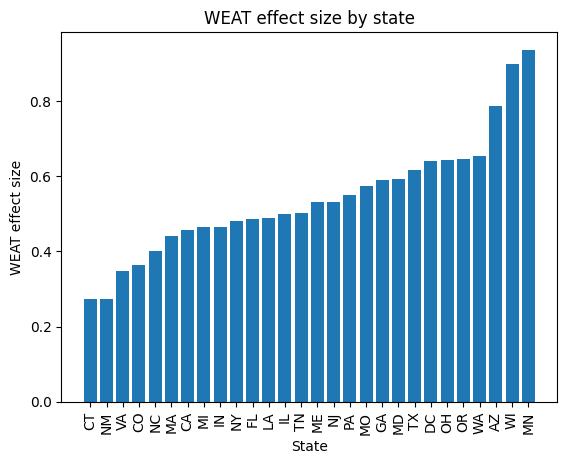

In [ ]:
# plot a chart that shows each state and its value from state_gendercareer

import matplotlib.pyplot as plt
#sort by value
state_gendercareer = dict(sorted(state_gendercareer.items(), key=lambda item: item[1]))
#plot
plt.bar(state_gendercareer.keys(), state_gendercareer.values())
#rotate x-axis labels
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('WEAT effect size')
plt.title('WEAT effect size by state')
plt.show()

In [ ]:
gay = ['gay', 'homosexual']
straight = ['straight', 'heterosexual']

good = [ "joyful", "lovely", "glorious", "pleasure", "wonderful"]
bad = [ "awful", "nasty", "terrible", "horrible", "painful"]

state_sexuality = {}

for state in states15mil:
  print(state)
  model = Word2Vec.load(os.path.join('/content/drive/MyDrive/Michelle Molly/Corpus Data/word2vec_models', state+"_word2vec.model"))
  state_sexuality[state] = weat_es(model, straight, gay, good, bad)

MN


KeyError: "Key 'heterosexual' not present"